In [3]:
#Prepare all our necessary libraries
import numpy as np 
#import pandas as pd 
import os
import matplotlib.pyplot as plt

#pytorch libraries
import torch
from torch.utils.data import Dataset
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, Resize

from torchvision.models import resnet50,wide_resnet50_2,shufflenet_v2_x0_5
import torchvision.transforms as transforms
from torch import nn
from torch.nn import init, Linear, ReLU, Softmax
from torch.nn.init import xavier_uniform_
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_

import datetime

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
train_dataset = SVHN(root='./', split='train',
                                             download=True, transform=transform)

test_dataset = SVHN(root='./', split='test',
                                            download=True, transform=transform)
print("训练集的图像数量为：", len(train_dataset))
print("测试集的图像数量为", len(test_dataset))

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat
训练集的图像数量为： 73257
测试集的图像数量为 26032


In [8]:
batch_size = 64  # 设置批次个数
# shuffle=True:表示加载数据前，会先打乱数据，提高模型的稳健性
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)
test_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f920b1767c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f920b1767c0>)

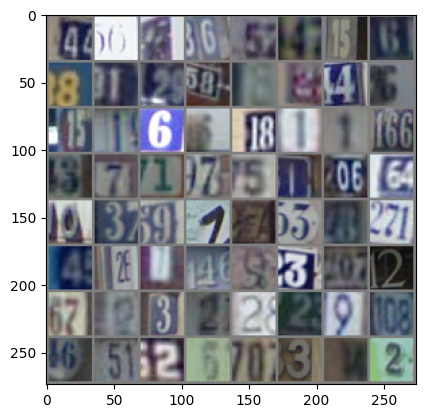

In [7]:
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline
def imshow(img):
    # 由于加载器产生的图片是归一化后的图片，因此这里需要将图片反归一化
    # 变成归一化前的图像
    img = img / 2 + 0.5
    # 将图像从 Tensor 转为 NumPy
    npimg = img.numpy()
    # 产生的数据为 C×W×H 而 plt 展示的图像一般都是 W×H×C
    # 因此，这里会有一个维度的变换
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 随机获得一些训练图像
dataiter = iter(train_loader)
images, labels = dataiter.next()
# 将这些图像进行展示
imshow(torchvision.utils.make_grid(images))

In [9]:
#downloading resent50 pretrained on ImageNet 
resn50 = resnet50(pretrained=True, progress = True)

#adjust resnet50 to my dataset
class r50(nn.Module):
    def __init__(self, pretrained_model):
        super(r50,self).__init__()
        self.rn50 = pretrained_model
        self.fl1 = nn.Linear(1000, 256)
        self.fl2 = nn.Linear(256,10)
        
    def forward(self, X):
        X = self.rn50(X)
        X = F.relu(self.fl1(X))
        X = F.dropout(X, p=0.25)
        X = self.fl2(X)
        return X

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
model = r50(resn50)
criterion = nn.CrossEntropyLoss(reduction = "mean")
optim = Adam(model.parameters(), lr = 0.001)

#put on cuda if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
nb_epochs = 15
accuracy = []
eps = 0.01
eps_iter = 0.001
steps = 20

for epoch in range(nb_epochs):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model.eval()
        model.train()
        optim.zero_grad()
        prediction = model(images).to(torch.float32)
        loss = criterion(prediction, labels.to(torch.long)) 
        loss.backward()
        optim.step()

        running_loss += loss.item()
        
        #calculate accuracy
        corrects = 0
        pred = torch.argmax(prediction, dim = 1)
        
        for i, p,l in zip(range(64), pred, labels):
            corrects += (p == l)
        accuracy.append(int(corrects)/len(pred))
    
    print("Epoch: {j}/{total_epochs} \t Time: {time} \t Loss: {Loss} \t Accuracy: {acc}".format(j = epoch+1,Loss = running_loss/len(train_loader),total_epochs = nb_epochs,time = datetime.datetime.now().time(), acc=np.mean(accuracy[-50:])))  

cuda:0
Epoch: 1/15 	 Time: 21:41:37.859956 	 Loss: 0.7289040287899659 	 Accuracy: 0.8794359756097561
Epoch: 2/15 	 Time: 21:42:46.908731 	 Loss: 0.5581587697936458 	 Accuracy: 0.7696341463414634
Epoch: 3/15 	 Time: 21:43:55.510649 	 Loss: 0.4359964326804902 	 Accuracy: 0.9039862804878049
Epoch: 4/15 	 Time: 21:45:02.978804 	 Loss: 0.38948613420193895 	 Accuracy: 0.9080487804878049
Epoch: 5/15 	 Time: 21:46:11.858701 	 Loss: 0.44571052977742065 	 Accuracy: 0.8746112804878049
Epoch: 6/15 	 Time: 21:47:21.168409 	 Loss: 0.34735590371112113 	 Accuracy: 0.924435975609756
Epoch: 7/15 	 Time: 21:48:31.389218 	 Loss: 0.2664706537752172 	 Accuracy: 0.9325
Epoch: 8/15 	 Time: 21:49:40.665298 	 Loss: 0.42659719885046304 	 Accuracy: 0.9074237804878049
Epoch: 9/15 	 Time: 21:50:49.330337 	 Loss: 0.289009081490956 	 Accuracy: 0.9244740853658537
Epoch: 10/15 	 Time: 21:51:58.674771 	 Loss: 0.22667815228476795 	 Accuracy: 0.9344740853658537
Epoch: 11/15 	 Time: 21:53:08.507111 	 Loss: 0.30853815211967

In [10]:
# save model for our test notebook    
PATH = './svhn_resnet50.pth'
torch.save(model.state_dict(), PATH)

In [11]:
model = r50(resn50)
model.load_state_dict(torch.load('./svhn_resnet50.pth'))
correct_test = 0
model.cuda(0)
model.eval() 
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        test_features, test_labels = data
        outputs = model(test_features.cuda(0))
        _,pred_idxs = torch.topk(outputs, 1)
        correct_test += torch.eq(test_labels.cuda(0), pred_idxs.squeeze()).sum().item()
print(correct_test/len(test_dataset))

0.9149508297480025


wide-resnet

In [12]:
#downloading Wide-ResNet-50 pretrained on ImageNet 
from torchvision.models import wide_resnet50_2
wresn50 = wide_resnet50_2(pretrained=True, progress = True)

#adjust Wide-ResNet-50 to my dataset
class wr50(nn.Module):
    def __init__(self, pretrained_model):
        super(wr50,self).__init__()
        self.wrn50 = pretrained_model
        self.fl1 = nn.Linear(1000, 256)
        self.fl2 = nn.Linear(256,10)
        
    def forward(self, X):
        X = self.wrn50(X)
        X = F.relu(self.fl1(X))
        X = F.dropout(X, p=0.25)
        X = self.fl2(X)
        return X

In [13]:
model = wr50(wresn50)
criterion = nn.CrossEntropyLoss(reduction = "mean")
optim = Adam(model.parameters(), lr = 0.001)

#put on cuda if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
nb_epochs = 15
accuracy = []
eps = 0.01
eps_iter = 0.001
steps = 20

for epoch in range(nb_epochs):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model.eval()
        model.train()
        optim.zero_grad()
        prediction = model(images).to(torch.float32)
        loss = criterion(prediction, labels.to(torch.long)) 
        loss.backward()
        optim.step()

        running_loss += loss.item()
        
        #calculate accuracy
        corrects = 0
        pred = torch.argmax(prediction, dim = 1)
        
        for i, p,l in zip(range(64), pred, labels):
            corrects += (p == l)
        accuracy.append(int(corrects)/len(pred))
    
    print("Epoch: {j}/{total_epochs} \t Time: {time} \t Loss: {Loss} \t Accuracy: {acc}".format(j = epoch+1,Loss = running_loss/len(train_loader),total_epochs = nb_epochs,time = datetime.datetime.now().time(), acc=np.mean(accuracy[-50:])))  

cuda:0
Epoch: 1/15 	 Time: 11:41:50.670916 	 Loss: 1.466830511046289 	 Accuracy: 0.7714710365853658
Epoch: 2/15 	 Time: 11:43:52.757158 	 Loss: 0.6134807175944466 	 Accuracy: 0.8579725609756097
Epoch: 3/15 	 Time: 11:45:51.032390 	 Loss: 0.4655950528955876 	 Accuracy: 0.7515091463414635
Epoch: 4/15 	 Time: 11:47:55.181561 	 Loss: 0.5613976723242015 	 Accuracy: 0.8586356707317073
Epoch: 5/15 	 Time: 11:50:03.876379 	 Loss: 0.5958809247248558 	 Accuracy: 0.8649237804878049
Epoch: 6/15 	 Time: 11:52:12.190873 	 Loss: 0.4829035843628983 	 Accuracy: 0.8911737804878049
Epoch: 7/15 	 Time: 11:54:11.482551 	 Loss: 0.3563071130046938 	 Accuracy: 0.901486280487805
Epoch: 8/15 	 Time: 11:56:17.064147 	 Loss: 0.44878522274470745 	 Accuracy: 0.8905106707317073
Epoch: 9/15 	 Time: 11:58:25.832415 	 Loss: 0.3183390730593402 	 Accuracy: 0.9139481707317073
Epoch: 10/15 	 Time: 12:00:34.953978 	 Loss: 0.41146708592837555 	 Accuracy: 0.9174618902439025
Epoch: 11/15 	 Time: 12:02:43.673083 	 Loss: 0.28831

In [14]:
# save model for our test notebook    
PATH = './svhn_wide_resnet50.pth'
torch.save(model.state_dict(), PATH)
model = wr50(wresn50)
model.load_state_dict(torch.load('./svhn_wide_resnet50.pth'))
correct_test = 0
model.cuda(0)
model.eval() 
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        test_features, test_labels = data
        outputs = model(test_features.cuda(0))
        _,pred_idxs = torch.topk(outputs, 1)
        correct_test += torch.eq(test_labels.cuda(0), pred_idxs.squeeze()).sum().item()
print(correct_test/len(test_dataset))

0.9168715427166564


In [16]:
from torchvision.models import squeezenet1_0
squ = squeezenet1_0(pretrained=True, progress = True)

#adjust Wide-ResNet-50 to my dataset
class squeezenet(nn.Module):
    def __init__(self, pretrained_model):
        super(squeezenet,self).__init__()
        self.squ = pretrained_model
        self.fl1 = nn.Linear(1000, 256)
        self.fl2 = nn.Linear(256,10)
        
    def forward(self, X):
        X = self.squ(X)
        X = F.relu(self.fl1(X))
        X = F.dropout(X, p=0.25)
        X = self.fl2(X)
        return X

model = squeezenet(squ)
criterion = nn.CrossEntropyLoss(reduction = "mean")
optim = Adam(model.parameters(), lr = 0.001)

#put on cuda if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
nb_epochs = 15
accuracy = []
eps = 0.01
eps_iter = 0.001
steps = 20

for epoch in range(nb_epochs):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model.eval()
        model.train()
        optim.zero_grad()
        prediction = model(images).to(torch.float32)
        loss = criterion(prediction, labels.to(torch.long)) 
        loss.backward()
        optim.step()

        running_loss += loss.item()
        
        #calculate accuracy
        corrects = 0
        pred = torch.argmax(prediction, dim = 1)
        
        for i, p,l in zip(range(64), pred, labels):
            corrects += (p == l)
        accuracy.append(int(corrects)/len(pred))
    
    print("Epoch: {j}/{total_epochs} \t Time: {time} \t Loss: {Loss} \t Accuracy: {acc}".format(j = epoch+1,Loss = running_loss/len(train_loader),total_epochs = nb_epochs,time = datetime.datetime.now().time(), acc=np.mean(accuracy[-50:])))



cuda:0
Epoch: 1/15 	 Time: 12:21:31.281667 	 Loss: 1.0912252864723122 	 Accuracy: 0.8454725609756097
Epoch: 2/15 	 Time: 12:21:53.621818 	 Loss: 0.4597100324896225 	 Accuracy: 0.886935975609756
Epoch: 3/15 	 Time: 12:22:16.104117 	 Loss: 0.393939106530758 	 Accuracy: 0.8968368902439025
Epoch: 4/15 	 Time: 12:22:38.404835 	 Loss: 0.35998483464837594 	 Accuracy: 0.9090243902439025
Epoch: 5/15 	 Time: 12:23:01.390061 	 Loss: 0.3438008745489683 	 Accuracy: 0.9074618902439024
Epoch: 6/15 	 Time: 12:23:23.804729 	 Loss: 0.31588972664425985 	 Accuracy: 0.9128125
Epoch: 7/15 	 Time: 12:23:46.429132 	 Loss: 0.3012576516864081 	 Accuracy: 0.9164862804878049
Epoch: 8/15 	 Time: 12:24:08.664735 	 Loss: 0.28790907198847904 	 Accuracy: 0.9313490853658537
Epoch: 9/15 	 Time: 12:24:31.460228 	 Loss: 0.27652978892214436 	 Accuracy: 0.9293368902439024
Epoch: 10/15 	 Time: 12:24:54.337465 	 Loss: 0.26678950880048186 	 Accuracy: 0.9292987804878049
Epoch: 11/15 	 Time: 12:25:16.596176 	 Loss: 0.26375142522

In [17]:
# save model for our test notebook    
PATH = './svhn_squeezenet.pth'
torch.save(model.state_dict(), PATH)
model = squeezenet(squ)
model.load_state_dict(torch.load('./svhn_squeezenet.pth'))
correct_test = 0
model.cuda(0)
model.eval() 
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        test_features, test_labels = data
        outputs = model(test_features.cuda(0))
        _,pred_idxs = torch.topk(outputs, 1)
        correct_test += torch.eq(test_labels.cuda(0), pred_idxs.squeeze()).sum().item()
print(correct_test/len(test_dataset))

0.9257068223724647
